<a href="https://colab.research.google.com/github/ywzhang909/C_and_Cplus_Projects/blob/master/%E7%AC%AC10%E7%AB%A0-Actor-Critic%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [ ]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [ ]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [ ]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 100/100 [00:00<00:00, 184.32it/s, episode=100,
# return=21.100]
# Iteration 1: 100%|██████████| 100/100 [00:01<00:00, 98.31it/s, episode=200,
# return=72.800]
# Iteration 2: 100%|██████████| 100/100 [00:01<00:00, 58.72it/s, episode=300,
# return=109.300]
# Iteration 3: 100%|██████████| 100/100 [00:04<00:00, 23.14it/s, episode=400,
# return=163.000]
# Iteration 4: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s, episode=500,
# return=193.600]
# Iteration 5: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s, episode=600,
# return=195.900]
# Iteration 6: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s, episode=700,
# return=199.100]
# Iteration 7: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s, episode=800,
# return=186.900]
# Iteration 8: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s, episode=900,
# return=200.000]
# Iteration 9: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s, episode=1000,
# return=200.000]

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  from ipykernel import kernelapp as app
Iteration 9: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s, episode=1000, return=200.000]


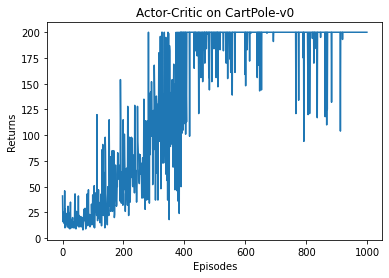

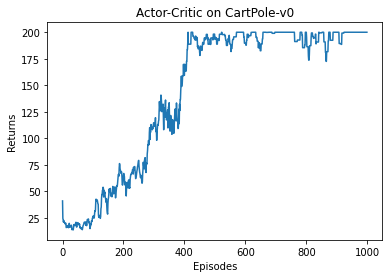

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

In [2]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
image_path = '/content/Pic_20241129201403604-1.bmp'

img = Image.open(image_path)
img_array = np.array(img)

In [7]:
# prompt: PIL read bmp file, then find the center of the spot light and boundary

from PIL import Image
import numpy as np

def find_spotlight_center_and_boundary(image_path):
    """
    Finds the center and boundary of a spotlight in a BMP image.

    Args:
        image_path: The path to the BMP image file.

    Returns:
        A tuple containing:
            - center: A tuple (x, y) representing the center of the spotlight.
            - boundary: A list of tuples (x, y) representing the boundary points of the spotlight.
        Returns None if the spotlight cannot be found or the image cannot be opened
    """
    try:
        img = Image.open(image_path)
        img_array = np.array(img)

        # Assuming the spotlight is brighter than the background
        # Find pixels above a certain threshold (adjust as needed)
        threshold = 128 # Example threshold, adjust based on image
        bright_pixels = np.where(img_array > threshold)

        if not bright_pixels[0].size:  # Check for empty bright_pixels
            return None

        # Calculate center of the spotlight
        center_x = int(np.mean(bright_pixels[1]))
        center_y = int(np.mean(bright_pixels[0]))
        center = (center_x, center_y)

        # Find boundary points using a simple contour finding approach
        # This could be enhanced using more sophisticated algorithms
        boundary = []
        for x,y in zip(bright_pixels[1], bright_pixels[0]):
            boundary.append((x,y))

        return center, boundary

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage:
# Assuming you have a 'spotlight.bmp' file
image_path = '/content/Pic_20241129201403604-1.bmp'  # Replace with your image path
result = find_spotlight_center_and_boundary(image_path)

if result:
  center, boundary = result
  print("Center of spotlight:", center)
  print("Boundary points:", boundary)

Center of spotlight: (2663, 1625)
Boundary points: [(2637, 1414), (2639, 1414), (2640, 1414), (2641, 1414), (2639, 1415), (2635, 1416), (2636, 1416), (2637, 1416), (2638, 1416), (2639, 1416), (2640, 1416), (2641, 1416), (2642, 1416), (2643, 1416), (2644, 1416), (2645, 1416), (2721, 1416), (2637, 1417), (2641, 1417), (2642, 1417), (2583, 1418), (2584, 1418), (2585, 1418), (2586, 1418), (2587, 1418), (2588, 1418), (2589, 1418), (2635, 1418), (2637, 1418), (2638, 1418), (2639, 1418), (2640, 1418), (2641, 1418), (2642, 1418), (2643, 1418), (2644, 1418), (2645, 1418), (2646, 1418), (2647, 1418), (2717, 1418), (2718, 1418), (2721, 1418), (2722, 1418), (2583, 1419), (2584, 1419), (2585, 1419), (2586, 1419), (2587, 1419), (2588, 1419), (2589, 1419), (2590, 1419), (2635, 1419), (2637, 1419), (2638, 1419), (2639, 1419), (2640, 1419), (2641, 1419), (2642, 1419), (2643, 1419), (2644, 1419), (2645, 1419), (2646, 1419), (2647, 1419), (2648, 1419), (2721, 1419), (2723, 1419), (2583, 1420), (2585, 142

In [8]:
# prompt: calculate the sharpness of the spot light

import numpy as np
from PIL import Image

def calculate_sharpness(image_path):
    """
    Calculates the sharpness of a spotlight in an image.

    Args:
        image_path: The path to the image file.

    Returns:
        The sharpness value (a higher value indicates a sharper spotlight).
        Returns None if the image cannot be processed.
    """
    try:
        img = Image.open(image_path).convert('L')  # Open as grayscale
        img_array = np.array(img)

        # Calculate the gradient magnitude using Sobel operator
        gradient_x = np.gradient(img_array, axis=1)
        gradient_y = np.gradient(img_array, axis=0)
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

        # Calculate the average gradient magnitude within a region of interest (ROI)
        # You might need to adjust the ROI based on your image.
        # For now, we'll use the entire image.
        sharpness = np.mean(gradient_magnitude)

        return sharpness

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
image_path = '/content/Pic_20241129201403604-1.bmp'  # Replace with your image path
sharpness = calculate_sharpness(image_path)

if sharpness is not None:
    print(f"Sharpness of the spotlight: {sharpness}")

Sharpness of the spotlight: 0.1495386612216264
